# Weather Prediction Using CNN



Adapted from https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install keras-tuner
!pip install statsmodels


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


## Training

## ADDING CNN, LSTMs


<ipython-input-3-570b4e60e61e>:41: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


Epoch 1/70
51/51 [==============================] - 15s 147ms/step - loss: 0.0443 - val_loss: 0.0382
Epoch 2/70
51/51 [==============================] - 3s 64ms/step - loss: 0.0167 - val_loss: 0.0380
Epoch 3/70
51/51 [==============================] - 3s 60ms/step - loss: 0.0165 - val_loss: 0.0366
Epoch 4/70
51/51 [==============================] - 3s 49ms/step - loss: 0.0128 - val_loss: 0.0282
Epoch 5/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0081 - val_loss: 0.0265
Epoch 6/70
51/51 [==============================] - 2s 49ms/step - loss: 0.0077 - val_loss: 0.0262
Epoch 7/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0264
Epoch 8/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0262
Epoch 9/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0265
Epoch 10/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0263
Epoch 1

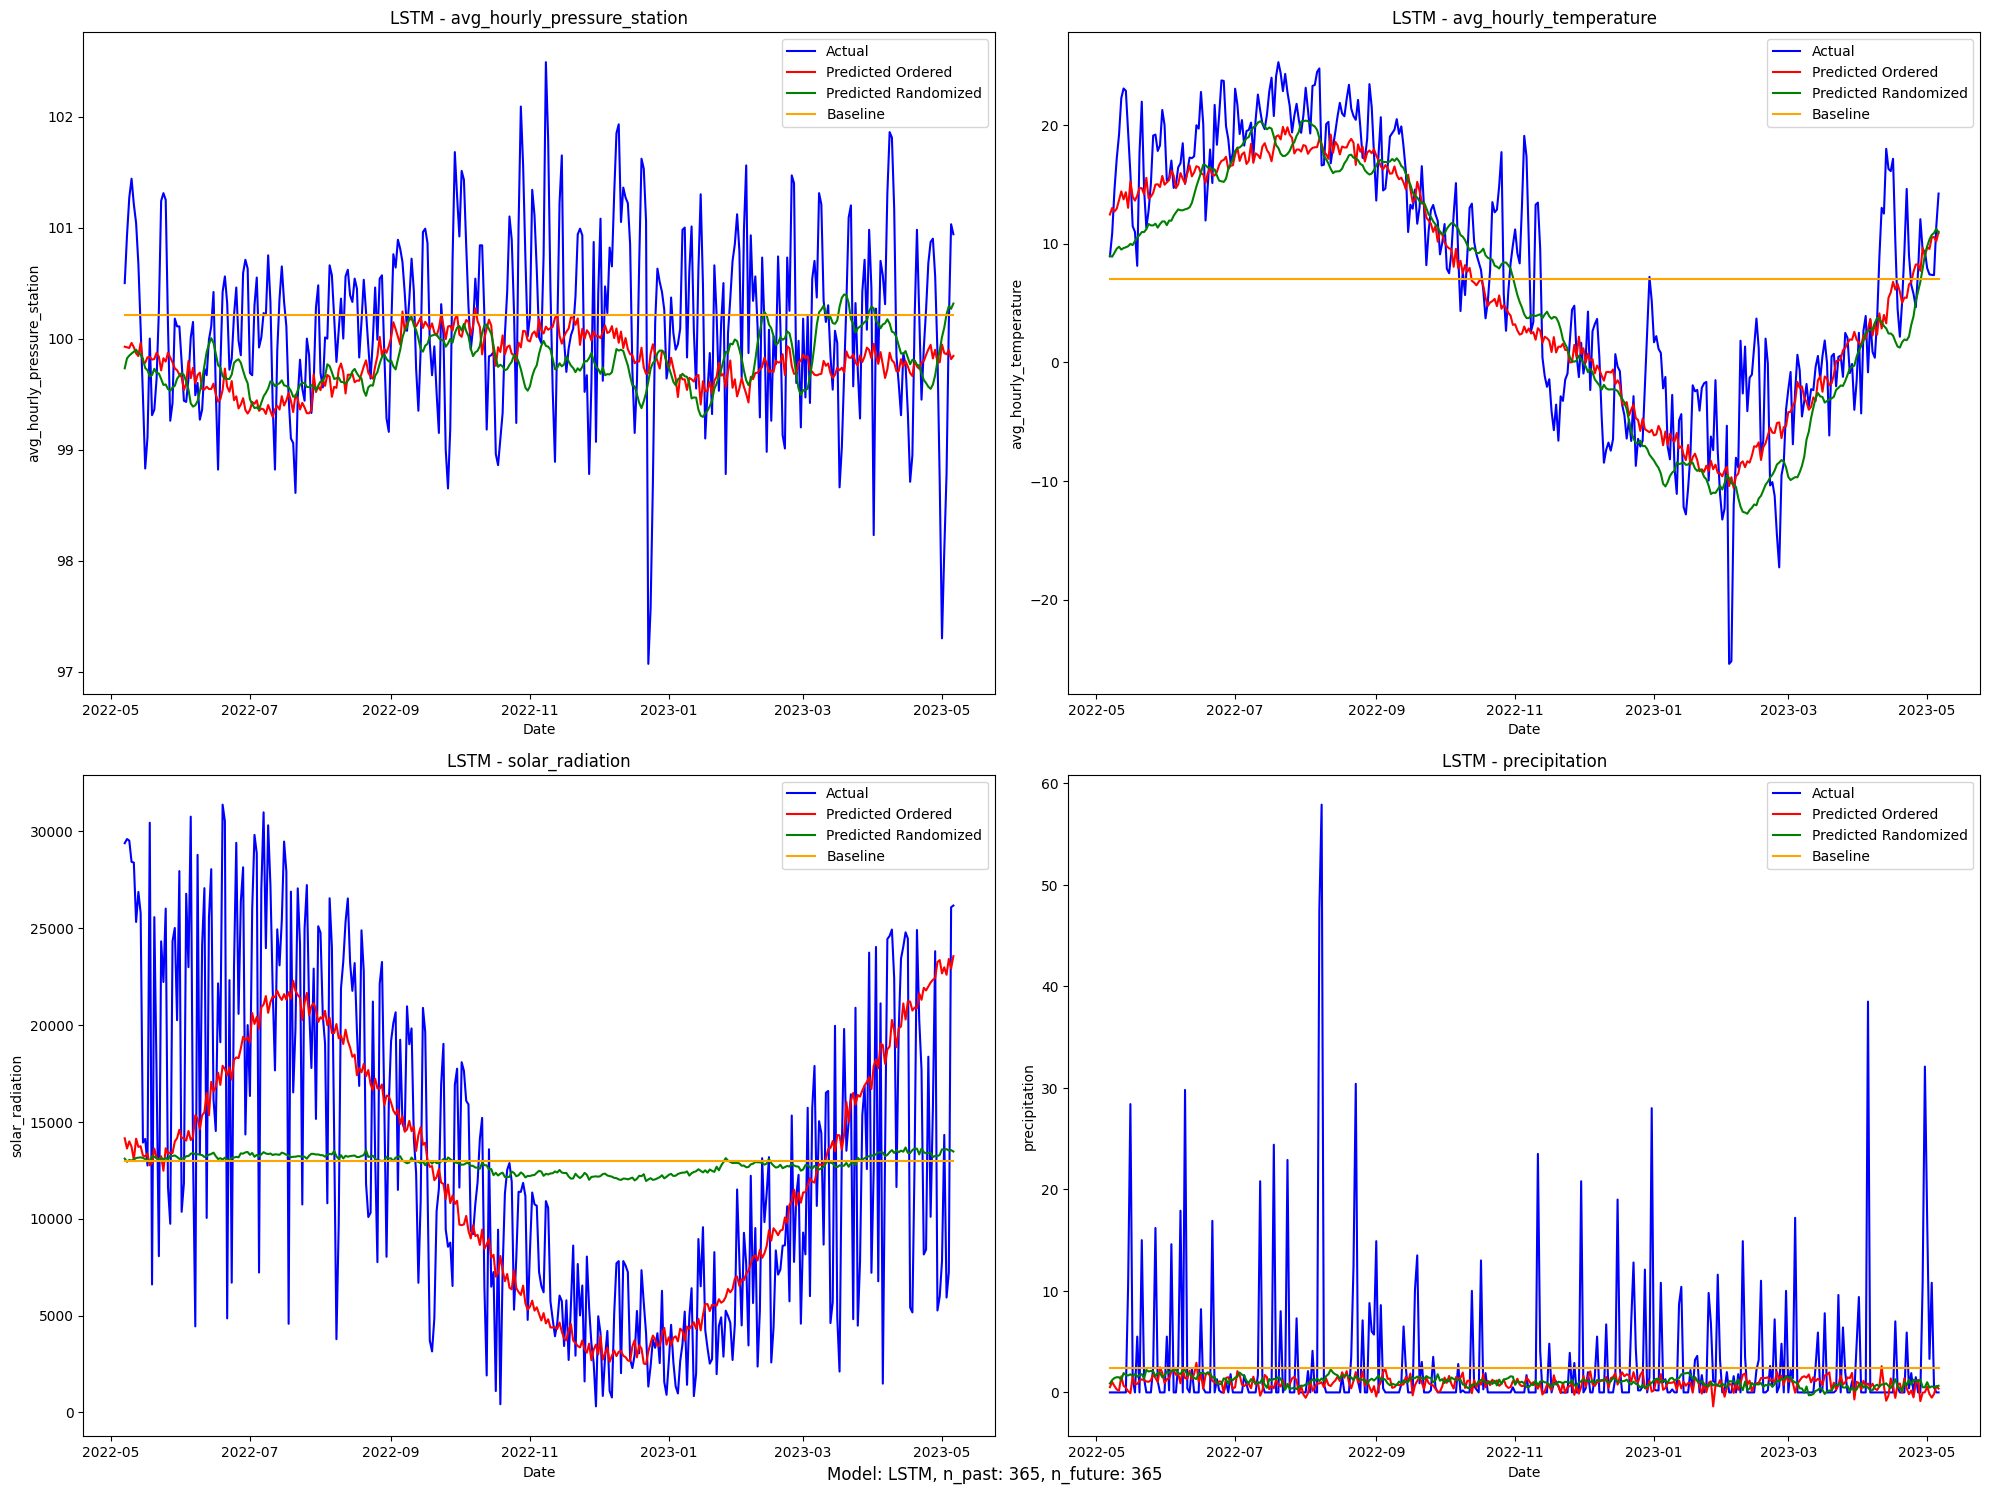

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband

def add_difference_features(df, features):
    """
    Add difference features to the dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.
        features (list): List of feature names to calculate the difference.

    Returns:
        pd.DataFrame: Dataframe with added difference features.
    """
    for feature in features:
        df[f'{feature}_diff'] = df[feature].diff().fillna(0)
    return df

def load_and_split_dataset(url, input_features, test_size=0.2, val_size=0.1):
    """
    Load dataset from URL and split into training, testing, and validation sets.

    Args:
        url (str): URL of the CSV dataset.
        input_features (list): List of feature names to be used as input.
        test_size (float): Proportion of the data to be used as test set.
        val_size (float): Proportion of the data to be used as validation set.

    Returns:
        tuple: Tuple containing training, testing, and validation dataframes.
    """
    df = pd.read_csv(url)
    df = df[['date'] + input_features]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['month'] = df.index.month
    df = df.sort_index()
    df.fillna(df.mean(), inplace=True)
    train_df, val_df = train_test_split(df, test_size=val_size, shuffle=False)
    train_df, test_df = train_test_split(train_df, test_size=test_size, shuffle=False)
    return train_df, test_df, val_df

class WeatherPredictionModel(HyperModel):
    """
    Weather prediction model using either CNN or LSTM architecture.

    Attributes:
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Testing dataset.
        val_df (pd.DataFrame): Validation dataset.
        n_past (int): Number of past time steps to consider for predictions.
        n_future_steps (int): Number of future time steps to predict.
        target_features (list): List of target features to predict.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        hyper_tuning (bool): Flag to enable hyperparameter tuning.
        model_type (str): Type of model ('CNN' or 'LSTM').
    """
    def __init__(self, train_df, test_df, val_df, target_features, n_past, n_future_steps, epochs=50, batch_size=8, hyper_tuning=True, model_type='CNN'):
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.n_past = n_past
        self.n_future_steps = n_future_steps
        self.target_features = target_features
        self.epochs = epochs
        self.batch_size = batch_size
        self.hyper_tuning = hyper_tuning
        self.model_type = model_type
        self.input_features = list(self.train_df.columns)
        self.scaler_train = MinMaxScaler()
        self.scaler_val = MinMaxScaler()
        self.scaler_test = MinMaxScaler()

    def preprocess_data(self, df, scaler, randomize=False):
        """
        Preprocess the data by scaling and creating time series sequences.

        Args:
            df (pd.DataFrame): Input dataframe.
            scaler (MinMaxScaler): Scaler for normalization.
            randomize (bool): Flag to enable data randomization.

        Returns:
            tuple: Tuple containing processed input data, target data, and the scaler.
        """
        df_scaled = scaler.fit_transform(df[self.input_features])
        X, y = [], []
        for i in range(self.n_past, len(df) - self.n_future_steps + 1):
            X.append(df_scaled[i - self.n_past:i])
            y.append(df_scaled[i:i + self.n_future_steps, [self.input_features.index(f) for f in self.target_features]])

        X, y = np.array(X), np.array(y)

        if randomize:
            # Randomly shuffle the arrays
            print("Randomizing array")
            X = np.repeat(X, 10, axis=0)
            y = np.repeat(y, 10, axis=0)
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X, y = X[indices], y[indices]

        return X, y, scaler

    def build(self, hp=None):
        """
        Build the model architecture based on the selected type and hyperparameters.

        Args:
            hp (HyperParameters): Hyperparameters object for tuning.

        Returns:
            Sequential: Compiled Keras model.
        """
        if hp is None:
            filters = 64
            kernel_size = 3
            pool_size = 2
            units = 128
            dropout = 0.3
            learning_rate = 1e-3
        else:
            filters = hp.Int('filters', min_value=32, max_value=128, step=32)
            kernel_size = hp.Choice('kernel_size', values=[2, 3, 4])
            pool_size = hp.Choice('pool_size', values=[2, 3])
            units = hp.Int('units', min_value=32, max_value=256, step=32)
            dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
            learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

        model = Sequential()
        if self.model_type == 'CNN':
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(self.n_past, len(self.input_features))))
            model.add(MaxPooling1D(pool_size=pool_size))
            model.add(Flatten())
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(dropout))
            model.add(Dense(len(self.target_features) * self.n_future_steps))
        elif self.model_type == 'LSTM':
            model.add(LSTM(units=units, return_sequences=True, input_shape=(self.n_past, len(self.input_features))))
            model.add(Dropout(dropout))
            model.add(LSTM(units=units))
            model.add(Dense(len(self.target_features) * self.n_future_steps))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def train_model(self, model, X_train, y_train, X_test, y_test):
        """
        Train the model using the training data.

        Args:
            model (Sequential): Keras model to be trained.
            X_train (np.array): Training input data.
            y_train (np.array): Training target data.
            X_test (np.array): Testing input data.
            y_test (np.array): Testing target data.

        Returns:
            History: Training history object.
        """
        history = model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, validation_data=(X_test, y_test), verbose=1)
        return history

    def evaluate_model(self, val_df, y_pred, scaler, model_name, randomize):
        """
        Evaluate the model performance using validation data.

        Args:
            val_df (pd.DataFrame): Validation dataframe.
            y_pred (np.array): Predicted target values.
            scaler (MinMaxScaler): Scaler for inverse transformation.
            model_name (str): Name of the model.
            randomize (bool): Flag to indicate if the data was randomized.

        Returns:
            list: List of dictionaries containing evaluation metrics.
        """
        y_pred_reshaped = y_pred.reshape(-1, len(self.target_features))
        y_pred_rescaled = scaler.inverse_transform(
            np.hstack([y_pred_reshaped, np.zeros((y_pred_reshaped.shape[0], len(self.input_features) - len(self.target_features)))]))[:, :len(self.target_features)]
        y_pred_rescaled = y_pred_rescaled.reshape(y_pred.shape)
        metrics = []

        for i, feature in enumerate(self.target_features):
            actual = val_df[feature].values[self.n_past:self.n_past + self.n_future_steps]
            predicted = y_pred_rescaled[0, :, i]

            mse = mean_squared_error(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            r2 = r2_score(actual, predicted)

            metrics.append({
                'Model': model_name,
                'Feature': feature,
                'n_past': self.n_past,
                'n_future': self.n_future_steps,
                'MSE': mse,
                'MAE': mae,
                'R2': r2,
                'Randomized': randomize
            })
        return metrics

    def plot_predictions(self, val_df, y_pred_ordered, y_pred_randomized, scaler, model_name, output_dir):
        """
        Plot the model predictions against actual values.

        Args:
            val_df (pd.DataFrame): Validation dataframe.
            y_pred_ordered (np.array): Predicted values without randomization.
            y_pred_randomized (np.array): Predicted values with randomization.
            scaler (MinMaxScaler): Scaler for inverse transformation.
            model_name (str): Name of the model.
            output_dir (str): Directory to save the plots.
        """
        y_pred_ordered_reshaped = y_pred_ordered.reshape(-1, len(self.target_features))
        y_pred_ordered_rescaled = scaler.inverse_transform(
            np.hstack([y_pred_ordered_reshaped, np.zeros((y_pred_ordered_reshaped.shape[0], len(self.input_features) - len(self.target_features)))]))[:, :len(self.target_features)]
        y_pred_ordered_rescaled = y_pred_ordered_rescaled.reshape(y_pred_ordered.shape)

        y_pred_randomized_reshaped = y_pred_randomized.reshape(-1, len(self.target_features))
        y_pred_randomized_rescaled = scaler.inverse_transform(
            np.hstack([y_pred_randomized_reshaped, np.zeros((y_pred_randomized_reshaped.shape[0], len(self.input_features) - len(self.target_features)))]))[:, :len(self.target_features)]
        y_pred_randomized_rescaled = y_pred_randomized_rescaled.reshape(y_pred_randomized.shape)

        dates = val_df.index[self.n_past:self.n_past + self.n_future_steps]
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = axes.flatten()

        # Calculate Baseline Predictions
        baseline_predictions = []
        for feature in self.target_features:
            baseline_predictions.append(np.mean(val_df[feature].values[:self.n_past]))

        for i, feature in enumerate(self.target_features):
            actual = val_df[feature].values[self.n_past:self.n_past + self.n_future_steps]
            predicted_ordered = y_pred_ordered_rescaled[0, :, i]
            predicted_randomized = y_pred_randomized_rescaled[0, :, i]
            baseline = [baseline_predictions[i]] * len(dates)

            ax = axes[i]
            ax.plot(dates, actual, color='blue', label='Actual')
            ax.plot(dates, predicted_ordered, color='red', label='Predicted Ordered')
            ax.plot(dates, predicted_randomized, color='green', label='Predicted Randomized')
            ax.plot(dates, baseline, color='orange', label='Baseline')
            ax.set_title(f'{model_name} - {feature}')
            ax.set_xlabel('Date')
            ax.set_ylabel(feature)
            ax.legend()

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.figtext(0.5, 0.01, f'Model: {model_name}, n_past: {self.n_past}, n_future: {self.n_future_steps}', ha='center', fontsize=12)
        plt.savefig(f"{output_dir}/{model_name}_n_past_{self.n_past}_n_future_{self.n_future_steps}.png")
        plt.show()

    def save_predictions_to_csv(self, val_df, y_pred, scaler, model_name, randomize, predictions_filename):
        """
        Save the model predictions to a CSV file.

        Args:
            val_df (pd.DataFrame): Validation dataframe.
            y_pred (np.array): Predicted target values.
            scaler (MinMaxScaler): Scaler for inverse transformation.
            model_name (str): Name of the model.
            randomize (bool): Flag to indicate if the data was randomized.
            predictions_filename (str): Filename to save predictions.
        """
        y_pred_reshaped = y_pred.reshape(-1, len(self.target_features))
        y_pred_rescaled = scaler.inverse_transform(
            np.hstack([y_pred_reshaped, np.zeros((y_pred_reshaped.shape[0], len(self.input_features) - len(self.target_features)))]))[:, :len(self.target_features)]
        y_pred_rescaled = y_pred_rescaled.reshape(y_pred.shape)

        dates = val_df.index[self.n_past:self.n_past + self.n_future_steps]
        data = {
            'Model': [model_name] * len(dates),
            'n_past': [self.n_past] * len(dates),
            'n_future': [self.n_future_steps] * len(dates),
            'Date': dates,
            'Randomized': [randomize] * len(dates)
        }

        for i, feature in enumerate(self.target_features):
            data[feature] = y_pred_rescaled[0, :, i]
            data[f'Actual_{feature}'] = val_df[feature].values[self.n_past:self.n_past + self.n_future_steps]

        df_predictions = pd.DataFrame(data)

        try:
            existing_df = pd.read_csv(predictions_filename)
            df_predictions = pd.concat([existing_df, df_predictions], ignore_index=True)
        except FileNotFoundError:
            pass

        df_predictions.to_csv(predictions_filename, index=False)

    def save_baseline_predictions_to_csv(self, val_df, predictions_filename):
        """
        Save baseline predictions to a CSV file.

        Args:
            val_df (pd.DataFrame): Validation dataframe.
            predictions_filename (str): Filename to save baseline predictions.
        """
        dates = val_df.index[self.n_past:self.n_past + self.n_future_steps]
        data = {
            'Model': ['Baseline'] * len(dates),
            'n_past': [self.n_past] * len(dates),
            'n_future': [self.n_future_steps] * len(dates),
            'Date': dates,
            'Randomized': [False] * len(dates)
        }

        for feature in self.target_features:
            data[feature] = np.mean(val_df[feature].values[:self.n_past])
            data[f'Actual_{feature}'] = val_df[feature].values[self.n_past:self.n_past + self.n_future_steps]

        df_predictions = pd.DataFrame(data)

        try:
            existing_df = pd.read_csv(predictions_filename)
            df_predictions = pd.concat([existing_df, df_predictions], ignore_index=True)
        except FileNotFoundError:
            pass

        df_predictions.to_csv(predictions_filename, index=False)

    def run(self, model_name, output_dir, predictions_filename, randomize=False):
        """
        Run the complete workflow: preprocess data, train model, and evaluate.

        Args:
            model_name (str): Name of the model.
            output_dir (str): Directory to save outputs.
            predictions_filename (str): Filename to save predictions.
            randomize (bool): Flag to indicate if the data should be randomized.

        Returns:
            tuple: Tuple containing evaluation metrics and predictions.
        """
        X_train, y_train, scaler_train = self.preprocess_data(self.train_df, self.scaler_train, randomize=randomize)
        X_test, y_test, scaler_test = self.preprocess_data(self.test_df, self.scaler_test, randomize=randomize)
        X_val, y_val, scaler_val = self.preprocess_data(self.val_df, self.scaler_val)

        y_train = y_train.reshape((y_train.shape[0], y_train.shape[1] * y_train.shape[2]))
        y_test = y_test.reshape((y_test.shape[0], y_test.shape[1] * y_test.shape[2]))
        y_val = y_val.reshape((y_val.shape[0], y_val.shape[1] * y_val.shape[2]))

        if self.hyper_tuning:
            tuner = Hyperband(
                self,
                objective='val_loss',
                max_epochs=50,
                factor=3,
                hyperband_iterations=1,
                directory='/content/drive/MyDrive/Keras Tuner',
                project_name='weather_prediction_ottawa_hourly')

            tuner.search(X_train, y_train, epochs=self.epochs, validation_data=(X_test, y_test), batch_size=self.batch_size)

            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hps)
        else:
            model = self.build()

        self.train_model(model, X_train, y_train, X_test, y_test)

        y_pred = model.predict(X_val)
        y_pred = y_pred.reshape((y_pred.shape[0], self.n_future_steps, len(self.target_features)))

        metrics = self.evaluate_model(self.val_df, y_pred, scaler_val, model_name, randomize)
        self.save_predictions_to_csv(self.val_df, y_pred, scaler_val, model_name, randomize, predictions_filename)
        return metrics, y_pred

def append_metrics_to_csv(metrics, filename):
    """
    Append the evaluation metrics to a CSV file.

    Args:
        metrics (list): List of dictionaries containing metrics.
        filename (str): Filename to save the metrics.
    """
    df_metrics = pd.DataFrame(metrics)
    try:
        existing_df = pd.read_csv(filename)
        df_metrics = pd.concat([existing_df, df_metrics], ignore_index=True)
    except FileNotFoundError:
        pass
    df_metrics.to_csv(filename, index=False)

def calculate_baseline_metrics(val_df, target_features, n_past, n_future_steps):
    """
    Calculate baseline metrics using mean predictions.

    Args:
        val_df (pd.DataFrame): Validation dataframe.
        target_features (list): List of target features.
        n_past (int): Number of past time steps.
        n_future_steps (int): Number of future time steps.

    Returns:
        list: List of dictionaries containing baseline metrics.
    """
    baseline_metrics = []
    for feature in target_features:
        actual = val_df[feature].values[n_past:n_past + n_future_steps]
        baseline = np.mean(val_df[feature].values[:n_past])
        predicted = [baseline] * n_future_steps

        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)

        baseline_metrics.append({
            'Model': 'Baseline',
            'Feature': feature,
            'n_past': n_past,
            'n_future': n_future_steps,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Randomized': False
        })
    return baseline_metrics

def run_and_collect_metrics(train_df, test_df, val_df, target_features, n_past_values, n_future_values, epochs, batch_size, hyper_tuning, metrics_filename, predictions_filename, output_dir):
    """
    Run the model for various configurations and collect metrics.

    Args:
        train_df (pd.DataFrame): Training dataframe.
        test_df (pd.DataFrame): Testing dataframe.
        val_df (pd.DataFrame): Validation dataframe.
        target_features (list): List of target features.
        n_past_values (list): List of past time steps to consider.
        n_future_values (list): List of future time steps to predict.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        hyper_tuning (bool): Flag to enable hyperparameter tuning.
        metrics_filename (str): Filename to save the metrics.
        predictions_filename (str): Filename to save predictions.
        output_dir (str): Directory to save plots.

    Returns:
        list: List of all collected metrics.
    """
    all_metrics = []
    # for model_type in ['CNN', 'LSTM']:
    for model_type in [ 'LSTM']:
        for n_past in n_past_values:
            for n_future in n_future_values:
                model_metrics_ordered = []
                model_metrics_randomized = []
                for _ in range(1):  # Run each model 1 time for each combination
                    model = WeatherPredictionModel(train_df, test_df, val_df, target_features, n_past, n_future, epochs, batch_size, hyper_tuning, model_type)

                    metrics_ordered, y_pred_ordered = model.run(f"{model_type}", output_dir, predictions_filename, randomize=False)
                    metrics_randomized, y_pred_randomized = model.run(f"{model_type}", output_dir, predictions_filename, randomize=True)

                    model.plot_predictions(val_df, y_pred_ordered, y_pred_randomized, model.scaler_val, model_type, output_dir)

                    model_metrics_ordered.extend(metrics_ordered)
                    model_metrics_randomized.extend(metrics_randomized)

                append_metrics_to_csv(model_metrics_ordered, metrics_filename)
                append_metrics_to_csv(model_metrics_randomized, metrics_filename)
                all_metrics.extend(model_metrics_ordered)
                all_metrics.extend(model_metrics_randomized)

    for n_past in n_past_values:
        for n_future in n_future_values:
            baseline_metrics = calculate_baseline_metrics(val_df, target_features, n_past, n_future)
            append_metrics_to_csv(baseline_metrics, metrics_filename)

            model = WeatherPredictionModel(train_df, test_df, val_df, target_features, n_past, n_future, epochs, batch_size, hyper_tuning, model_type)
            model.save_baseline_predictions_to_csv(val_df, predictions_filename)
            all_metrics.extend(baseline_metrics)
    return all_metrics

# Example usage
input_features = ['avg_hourly_pressure_station', 'avg_hourly_temperature', 'solar_radiation', 'precipitation']
target_features = ['avg_hourly_pressure_station', 'avg_hourly_temperature', 'solar_radiation', 'precipitation']
url = 'https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv'
train_df, test_df, val_df = load_and_split_dataset(url, input_features)

n_past_values = [ 365]
n_future_values = [ 365]

epochs = 70
batch_size = 128
hyper_tuning = False
metrics_filename = '/content/drive/MyDrive/CSI6900/weather_prediction_metrics.csv'
predictions_filename = '/content/drive/MyDrive/CSI6900/weather_predictions.csv'
output_dir = '/content/drive/MyDrive/CSI6900/model_plots'

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

all_metrics = run_and_collect_metrics(train_df, test_df, val_df, target_features, n_past_values, n_future_values, epochs, batch_size, hyper_tuning, metrics_filename, predictions_filename, output_dir)
